# MSDS 631 Final Project
## Mask Classification

In [11]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

### Creating data info dataframe

In [2]:
path = '/Users/juyeki/Documents/USF_MSDS/SummerModule2/631_DeepLearning/MSDS631_FinalProject/data'

def get_info(path, info, label, dataset):
    """Get info of all images in specified path"""
    for img in os.listdir(path):
        row = {} 
        row['dataset'] = dataset
        row['image_path'] = f'{path}/{img}'
        row['image'] = img
        row['label'] = label
        info.append(row)
    return info 

info = [] 
info = get_info(f'{path}/Train/Mask', info, 'mask', 'train')
info = get_info(f'{path}/Train/Non Mask', info, 'no mask', 'train')
info = get_info(f'{path}/Validation/Mask', info, 'mask', 'valid')
info = get_info(f'{path}/Validation/Non Mask', info, 'no mask', 'valid')
info = get_info(f'{path}/Test/Mask', info, 'mask', 'test')
info = get_info(f'{path}/Test/Non Mask', info, 'no mask', 'test')
info_df = pd.DataFrame(info)
# Save dataframe
info_df.to_csv('/Users/juyeki/Documents/USF_MSDS/SummerModule2/631_DeepLearning/MSDS631_FinalProject/data_info.csv', index=False)
info_df.head()

,dataset,image_path,image,label
0,train,/Users/juyeki/Documents/USF_MSDS/SummerModule2...,1409.jpg,mask
1,train,/Users/juyeki/Documents/USF_MSDS/SummerModule2...,0515.png,mask
2,train,/Users/juyeki/Documents/USF_MSDS/SummerModule2...,0930.jpg,mask
3,train,/Users/juyeki/Documents/USF_MSDS/SummerModule2...,0273.jpg,mask
4,train,/Users/juyeki/Documents/USF_MSDS/SummerModule2...,0267.jpg,mask


### Preprocess Images (Resize)

In [3]:
for img_path in info_df.image_path: 
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    cv2.imwrite(img_path, img)

### Creating Dataset Class

In [4]:
class MaskDataset(Dataset):
    def __init__(self, df): 
        self.df = df 
        self.mask_dict = {'no mask': 0, 'mask': 1}
        self.transformations = A.Compose([
            # Spatial Transformations 
            A.HorizontalFlip(),
            A.VerticalFlip(), 
            A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.75),
            
            # Pixel Transformations
            A.RandomBrightnessContrast(p=0.5),
            
            ToTensorV2()   
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Read in Image and Convert/Transform
        img = cv2.imread(row.image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        img_transform = self.transformations(image=img.astype(np.uint8))
        img_transform = img_transform['image']
        img_transform = torch.tensor(img_transform / 255.).float()
        
        label = torch.tensor(self.mask_dict[row.label])
        
        return img_transform, label
        

In [5]:
# Creating Training/Validation Datasets and DataLoaders 
train_df = info_df[info_df['dataset'] == 'train'].reset_index(drop=True)
valid_df = info_df[info_df['dataset'] == 'valid'].reset_index(drop=True)

train_df = train_df.iloc[:10]
valid_df = valid_df.iloc[:10]

train_ds = MaskDataset(train_df)
valid_ds = MaskDataset(valid_df)

train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=10, shuffle=True)

Dataset image dimensions: torch.Size([3, 128, 128])
After transformation image dimensions: (128, 128, 3)


<ipython-input-4-bf271bb8d9ef>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_transform = torch.tensor(img_transform / 255.).float()


(-0.5, 127.5, 127.5, -0.5)

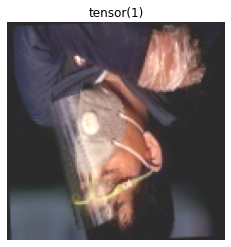

In [6]:
# Test the Dataset class is working properly 
img, label = next(iter(train_ds))
print(f'Dataset image dimensions: {img.shape}')
img = np.transpose(np.array(img), (1,2,0))
print(f'After transformation image dimensions: {img.shape}')
plt.imshow(img)
plt.title(label) # 1: mask, 0: no mask
plt.axis('off')

### Fitting Models
* CNN (from Scratch) 
* AlexNet
* ResNet 
* RNN?

In [7]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in dataloader:
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

#### Convolutional Neural Network (CNN)

In [8]:
class MaskCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(4096, 100)
        self.linear2 = nn.Linear(100, 2) # 2 output classes
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.relu = nn.ReLU()
        
        self.unroll = nn.Flatten()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.relu(self.linear1(self.unroll(x)))
        x = self.linear2(x)
        return x

In [9]:
model = MaskCNN()
lossFun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
summary(model, input_size = (3, 128, 128), device='cpu')

In [ ]:
# Train and Validate Model for 5 epochs
train_losses = []
valid_losses = []

for epoch in range(5):
    print(f'Epoch: {epoch}')
    
    train_loss = one_pass(model, train_dl, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: {train_loss}')
    
    valid_loss = one_pass(model, valid_dl, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: {valid_loss}')
    
    train_acc = one_pass_acc(model, train_dl, len(train_ds))
    valid_acc = one_pass_acc(model, valid_dl, len(valid_ds))
    print('Train Acc: {train_acc}')
    print('Valid Acc: {valid_acc}')